In [1]:
#Install Required Libraries
!pip install vaderSentiment



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


**2. Import Libraries**

In [2]:
#Import Libraries
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**3. Load Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")   # replace your dataset name
df = df.rename(columns={"review": "text", "tweet": "text"})
df = df.dropna(subset=["text"])
df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**4.Cleaning Function**

In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)        # remove URLs
    text = re.sub(r"@\w+", "", text)                 # remove mentions
    text = re.sub(r"#", "", text)                     # remove hashtags symbol
    text = re.sub(r"[^a-z0-9\s']", " ", text)         # remove special chars
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    return text

df["clean"] = df["text"].apply(clean_text)
df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didn't today must mean i need to take anothe...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it's really aggressive to blast obnoxious ente...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


**5.Preprocessing (Tokenization, Stopwords, Lemmatization)**

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

df["processed"] = df["clean"].apply(preprocess)
df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean,processed
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...,plus 've added commercial experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didn't today must mean i need to take anothe...,n't today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it's really aggressive to blast obnoxious ente...,'s really aggressive blast obnoxious entertain...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it,'s really big bad thing


**6.Sentiment Analysis VADER**

In [6]:
analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(text)["compound"]

df["vader"] = df["processed"].apply(vader_score)


**7.sentiment Analysis using text blob**

In [7]:
def tb_polarity(text):
    return TextBlob(text).sentiment.polarity

df["tb_polarity"] = df["processed"].apply(tb_polarity)


**7.Sentiment Classification**

In [8]:
def classify(compound):
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["vader"].apply(classify)
df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean,processed,vader,tb_polarity,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,said,0.0000,0.00000,Neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...,plus 've added commercial experience tacky,0.0000,0.00000,Neutral
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didn't today must mean i need to take anothe...,n't today must mean need take another trip,0.0000,-0.31250,Neutral
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it's really aggressive to blast obnoxious ente...,'s really aggressive blast obnoxious entertain...,-0.3306,0.00625,Negative
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it,'s really big bad thing,-0.5829,-0.35000,Negative


**counts of all the category**

In [9]:
df["sentiment"].value_counts()



sentiment
Positive    6535
Negative    4513
Neutral     3592
Name: count, dtype: int64

**8.Sentiment Distribution Visualization**

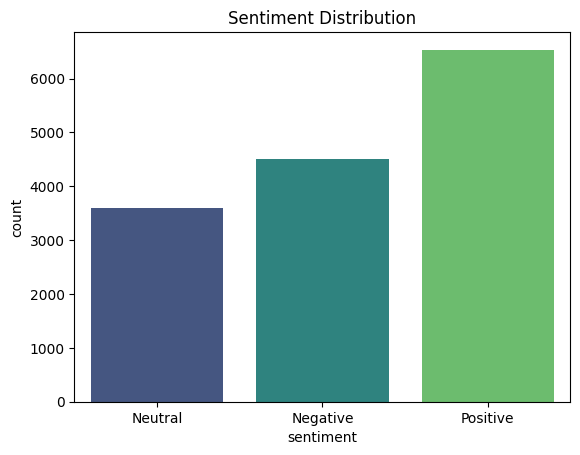

In [10]:
sns.countplot(data=df, x="sentiment", palette="viridis")
plt.title("Sentiment Distribution")
plt.show()



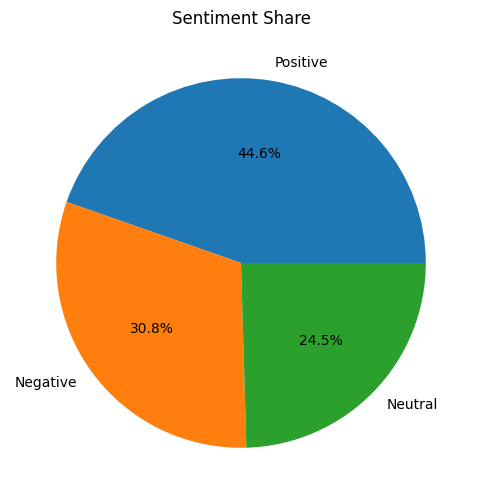

In [11]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Sentiment Share")
plt.ylabel("")
plt.show()

**9.WordCloud — Positive**

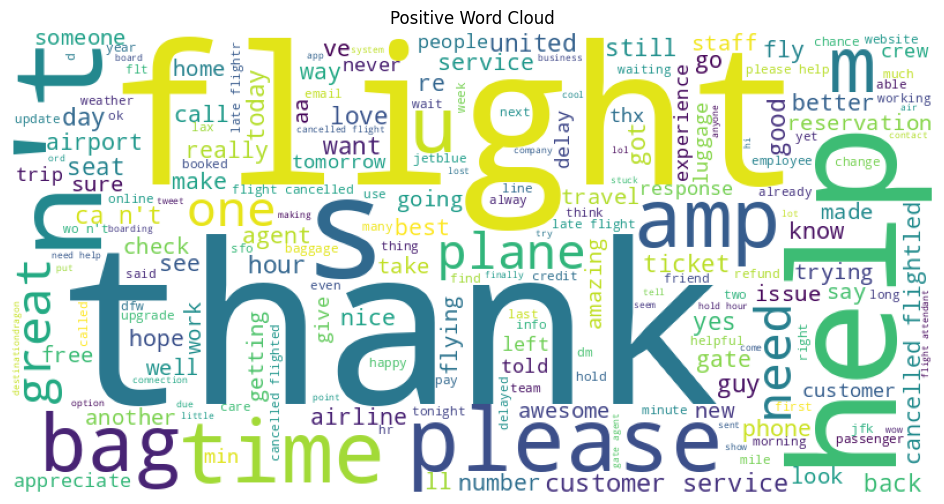

In [12]:
positive_text = " ".join(df[df.sentiment=="Positive"]["processed"])
wc = WordCloud(width=800, height=400, background_color="white").generate(positive_text)

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.title("Positive Word Cloud")
plt.show()


**10.WordCloud — Negative**

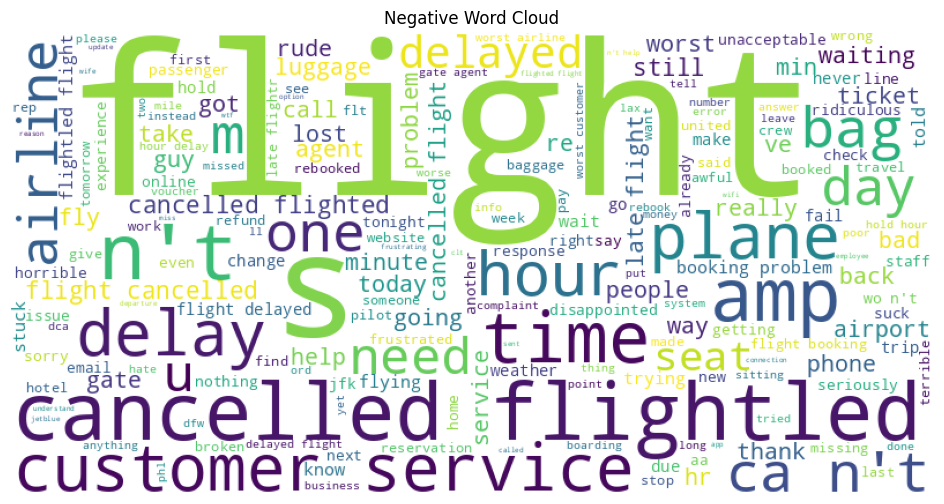

In [13]:
negative_text = " ".join(df[df.sentiment=="Negative"]["processed"])
wc = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.title("Negative Word Cloud")
plt.show()


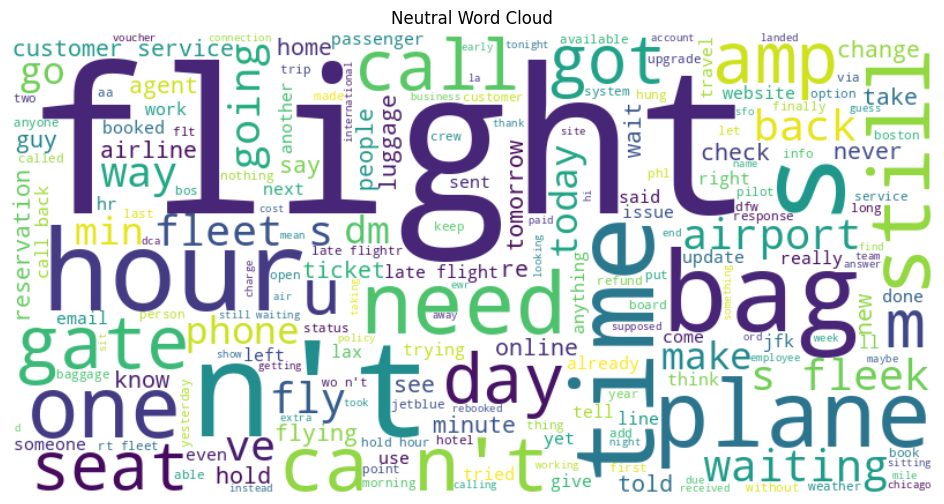

In [14]:

neutral_text = " ".join(df[df.sentiment=="Neutral"]["processed"])

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color="white").generate(neutral_text)

# Plot the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Word Cloud")
plt.show()


In [15]:
print(df.columns)


Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'clean', 'processed', 'vader',
       'tb_polarity', 'sentiment'],
      dtype='object')


**save the result**

In [16]:
df.to_csv("sentiment_results.csv", index=False)
print("Saved as sentiment_results.csv")


Saved as sentiment_results.csv


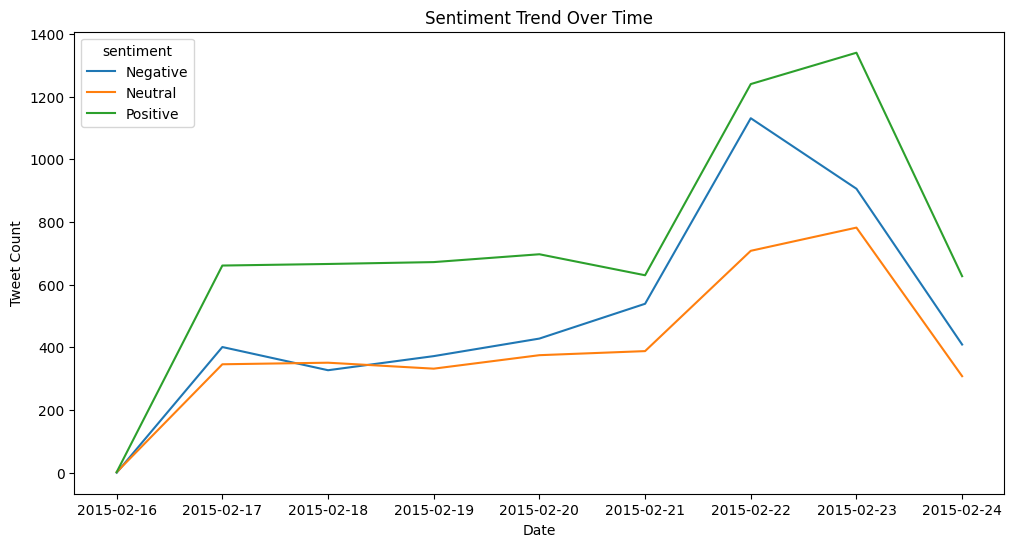

In [17]:
# Convert tweet_created into a clean date column
df["Date"] = pd.to_datetime(df["tweet_created"]).dt.date

# Group by date and sentiment
daily_sentiment = df.groupby(["Date", "sentiment"]).size().unstack().fillna(0)

# Plot trend over time
daily_sentiment.plot(kind='line', figsize=(12, 6))
plt.title("Sentiment Trend Over Time")
plt.ylabel("Tweet Count")
plt.xlabel("Date")
plt.show()


In [18]:
#Most Common Words per Sentiment
from collections import Counter

def word_freq(sentiment):
    words = " ".join(df[df['sentiment']==sentiment]['clean']).split()
    return Counter(words).most_common(20)

word_freq("Positive")
word_freq("Negative")
word_freq("Neutral")


[('to', 1913),
 ('i', 1314),
 ('the', 1298),
 ('on', 1051),
 ('a', 914),
 ('for', 817),
 ('flight', 798),
 ('and', 737),
 ('you', 733),
 ('my', 627),
 ('in', 585),
 ('is', 581),
 ('it', 459),
 ('of', 430),
 ('have', 427),
 ('me', 393),
 ('no', 384),
 ('not', 347),
 ('at', 345),
 ('that', 331)]

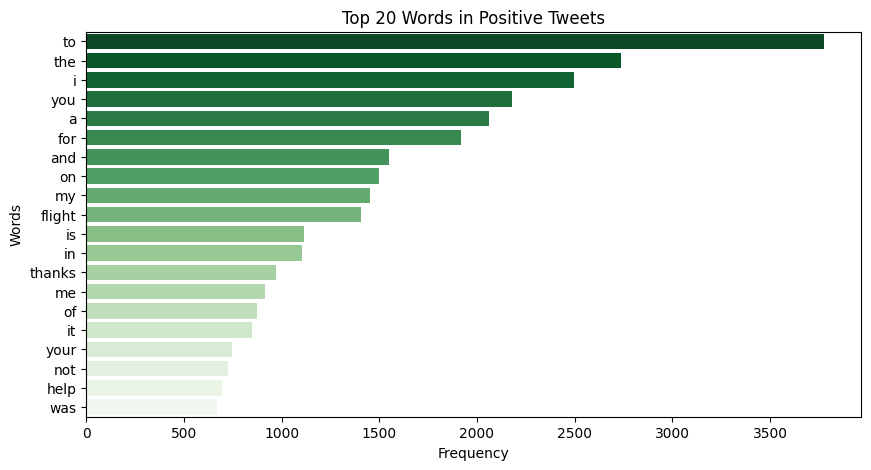

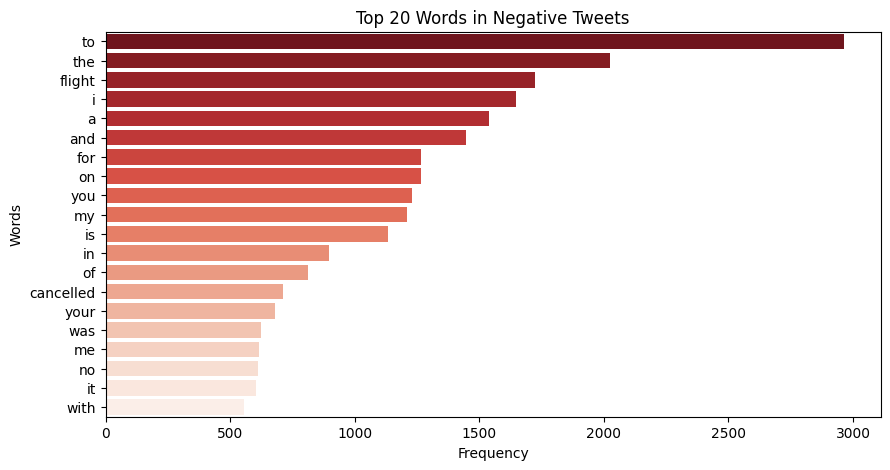

In [19]:
pos_freq = Counter(" ".join(df[df['sentiment']=='Positive']['clean']).split()).most_common(20)
neg_freq = Counter(" ".join(df[df['sentiment']=='Negative']['clean']).split()).most_common(20)

pos_df = pd.DataFrame(pos_freq, columns=['Word','Count'])
neg_df = pd.DataFrame(neg_freq, columns=['Word','Count'])
# Positive words
plt.figure(figsize=(10,5))
sns.barplot(data=pos_df, x='Count', y='Word', palette='Greens_r')
plt.title("Top 20 Words in Positive Tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# Negative words
plt.figure(figsize=(10,5))
sns.barplot(data=neg_df, x='Count', y='Word', palette='Reds_r')
plt.title("Top 20 Words in Negative Tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

/tmp/ipykernel_13/4205633341.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


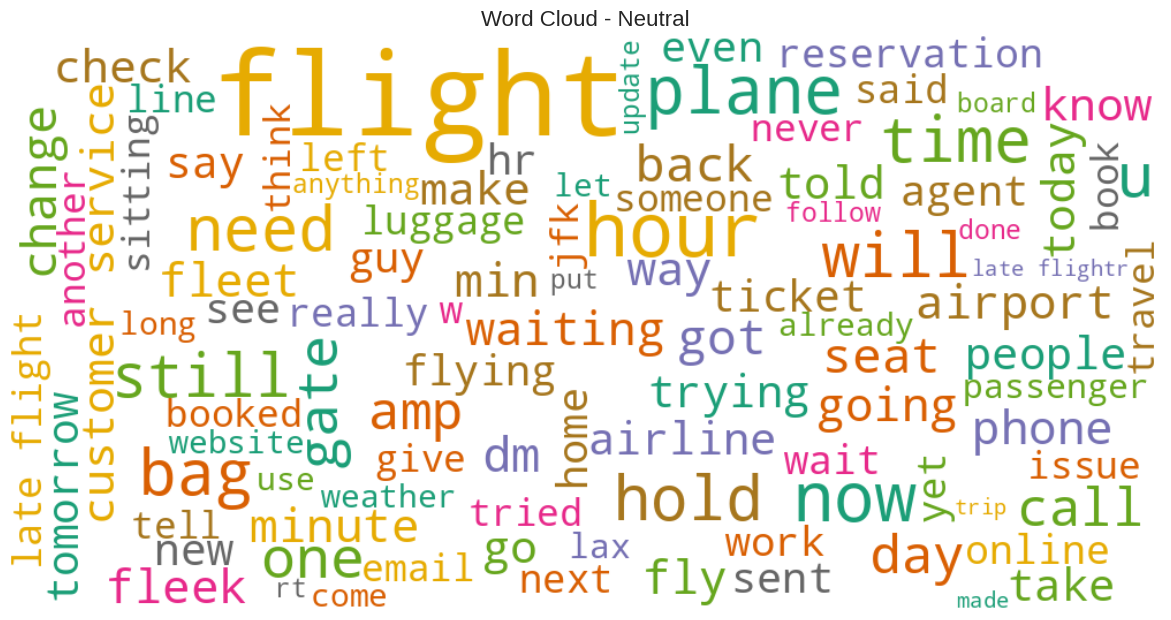

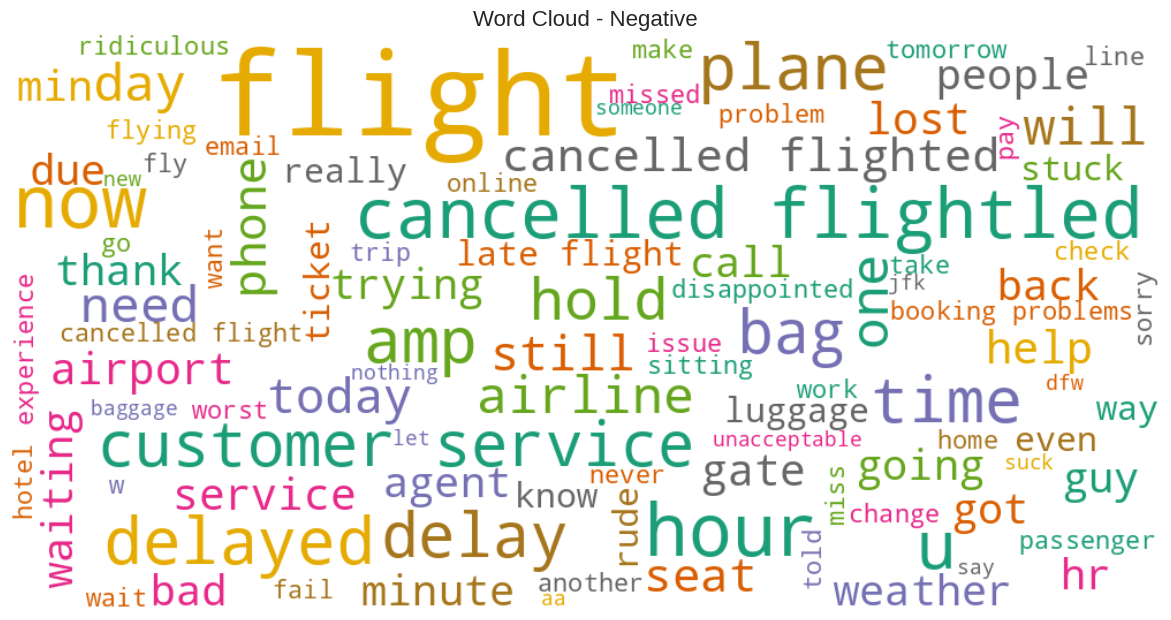

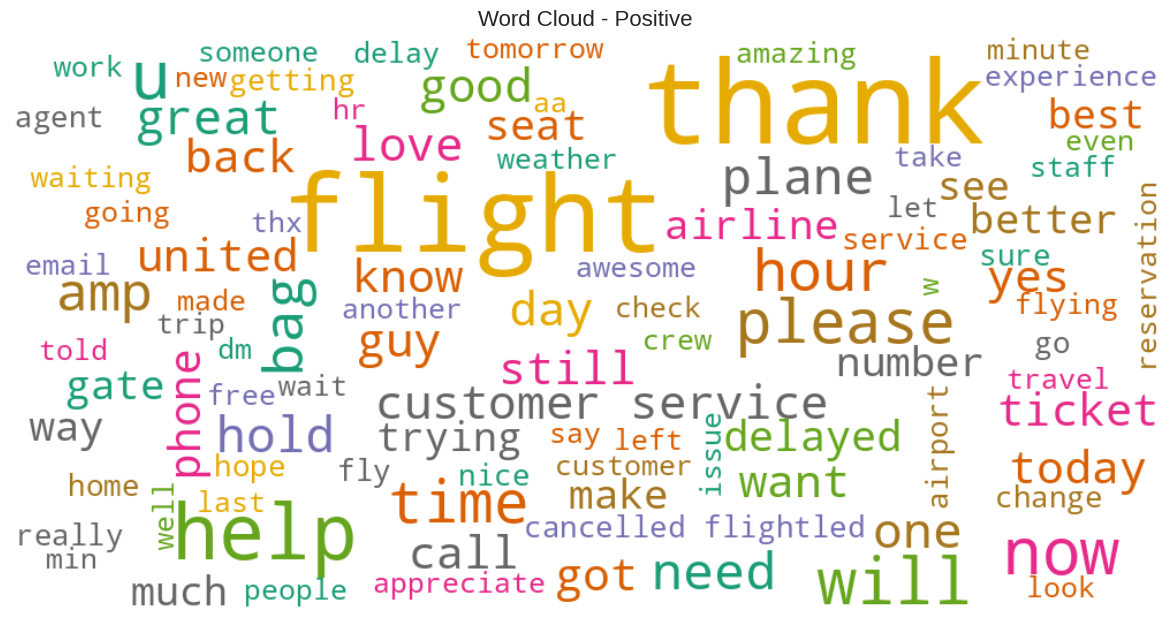

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

for s in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == s]['clean'])
    
    wc = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='Dark2',         # Changed to a more visible color palette
        max_words=100,
        max_font_size=100,
        random_state=42
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - {s.capitalize()}", fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()

In [21]:
daily_total = daily_sentiment.sum(axis=1)
spikes = daily_total[daily_total > daily_total.mean() * 1.3]  # 30% above avg
spikes


Date
2015-02-22    3079.0
2015-02-23    3028.0
dtype: float64

In [22]:
spike_date = spikes.index[0]   # choose first spike
df[df['Date'] == spike_date].head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_coord,tweet_created,tweet_location,user_timezone,clean,processed,vader,tb_polarity,sentiment,Date
120,569748316776325120,negative,0.6832,Customer Service Issue,0.3773,Virgin America,NaN,usagibrian,NaN,0,...,NaN,2015-02-22 22:39:18 -0800,San Francisco CA,Pacific Time (US & Canada),use another browser 2015 amp a brand with a re...,use another browser 2015 amp brand reputation ...,0.0000,0.000,Neutral,2015-02-22
121,569741221783957504,negative,1.0000,Flight Booking Problems,0.6767,Virgin America,NaN,usagibrian,NaN,0,...,NaN,2015-02-22 22:11:07 -0800,San Francisco CA,Pacific Time (US & Canada),and now the flight flight booking problems sit...,flight flight booking problem site totally fol...,-0.6887,0.000,Negative,2015-02-22
122,569737603617943552,negative,1.0000,Customer Service Issue,0.6527,Virgin America,NaN,KindofLuke,NaN,0,...,NaN,2015-02-22 21:56:44 -0800,NaN,NaN,i like the customer service but a 40 min delay...,like customer service 40 min delay connecting ...,0.0516,-0.050,Positive,2015-02-22
123,569714127792254976,positive,1.0000,NaN,NaN,Virgin America,NaN,ptbrodie,NaN,0,...,NaN,2015-02-22 20:23:27 -0800,San Francisco,NaN,thanks to your outstanding nyc jfk crew who mo...,thanks outstanding nyc jfk crew moved mountain...,0.7845,0.350,Positive,2015-02-22
124,569675144353828864,positive,1.0000,NaN,NaN,Virgin America,NaN,cheryleng,NaN,0,...,"[33.9469039, -118.40716847]",2015-02-22 17:48:33 -0800,NaN,Pacific Time (US & Canada),you have the absolute best team and customer s...,absolute best team customer service ever every...,0.8750,0.675,Positive,2015-02-22


In [23]:
top_positive = df.sort_values(by='vader', ascending=False).head(10)[['text','vader']]
top_negative = df.sort_values(by='vader').head(10)[['text','vader']]
print("Top Positive Tweets:")
print(top_positive.to_string(index=False))

print("\nTop Negative Tweets:")
print(top_negative.to_string(index=False))

Top Positive Tweets:
                                                                                                                                              text  vader
       @SouthwestAir I love this airline so much! Thanks so much! The service is great! The snacks are amazing! Everything is outstanding thanks!! 0.9716
                                           @JetBlue huge fan of great brands and people doing great things… you guys rock happy to share the love! 0.9716
               @SouthwestAir great cabin and flight crew this morning on #578. A great smile and happy staff are signs of a happy company. Thanks. 0.9682
       @AmericanAir I love the service and cheap upgrades American Provides! One of the best airlines ever! good food, good seats, amazing thanks! 0.9678
   @SouthwestAir do you have any info about when #DestinationDragons winners will be announced? me &amp; my best friend are hoping to win. thanks! 0.9670
                                     @JetBlue I wish yo

In [24]:
top_positive.to_csv("top_positive_tweets.csv", index=False)
top_negative.to_csv("top_negative_tweets.csv", index=False)

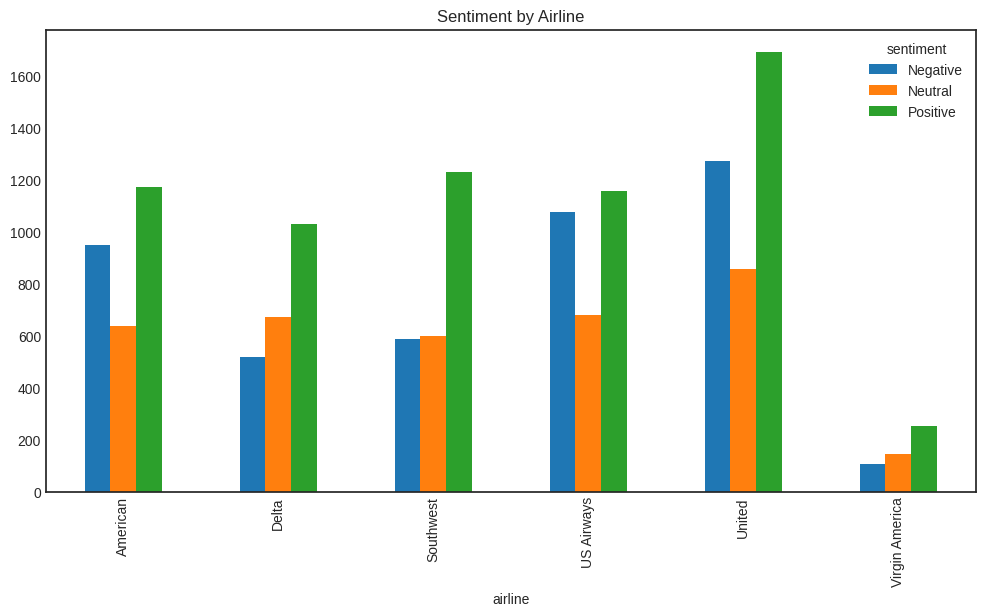

In [25]:
airline_sent = df.groupby(['airline','sentiment']).size().unstack().fillna(0)
airline_sent.plot(kind='bar', figsize=(12,6))
plt.title("Sentiment by Airline")
plt.show()


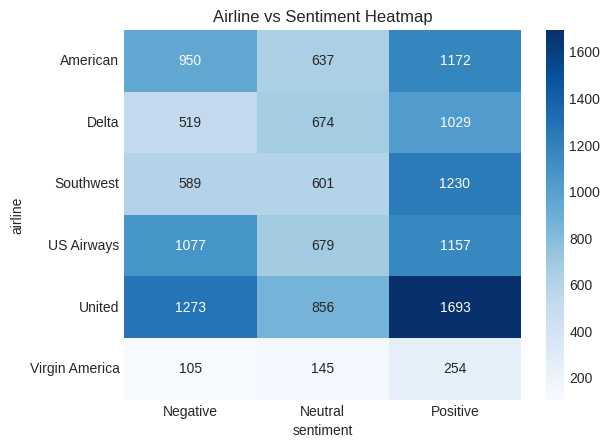

In [26]:
sns.heatmap(airline_sent, annot=True, fmt="d", cmap="Blues")
plt.title("Airline vs Sentiment Heatmap")
plt.show()


**Machine learning model**

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df["clean"])
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)


0.7848360655737705

In [28]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(scores.mean())

0.7834016393442623


              precision    recall  f1-score   support

    Negative       0.81      0.74      0.77       936
     Neutral       0.73      0.74      0.74       756
    Positive       0.80      0.85      0.82      1236

    accuracy                           0.78      2928
   macro avg       0.78      0.78      0.78      2928
weighted avg       0.79      0.78      0.78      2928



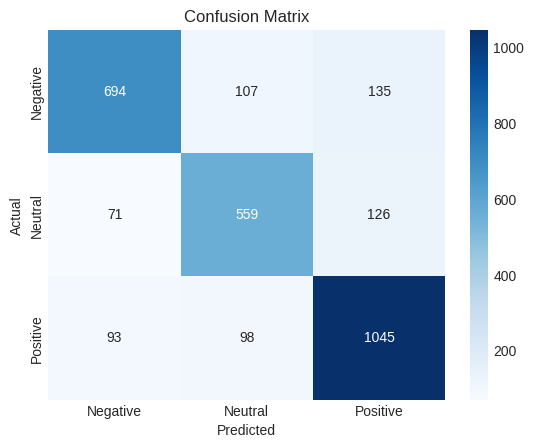

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)

# Detailed report
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
df['sentiment'].value_counts()


sentiment
Positive    6535
Negative    4513
Neutral     3592
Name: count, dtype: int64

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 500, 'solver': 'liblinear'}
Best CV score: 0.8008027618652941


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       0.76      0.60      0.67       924
     Neutral       0.78      0.11      0.19       721
    Positive       0.58      0.94      0.71      1283

    accuracy                           0.63      2928
   macro avg       0.71      0.55      0.53      2928
weighted avg       0.69      0.63      0.57      2928



In [33]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       0.81      0.75      0.78       924
     Neutral       0.74      0.81      0.77       721
    Positive       0.85      0.84      0.84      1283

    accuracy                           0.80      2928
   macro avg       0.80      0.80      0.80      2928
weighted avg       0.81      0.80      0.81      2928



In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       0.80      0.72      0.76       924
     Neutral       0.70      0.88      0.78       721
    Positive       0.87      0.80      0.83      1283

    accuracy                           0.80      2928
   macro avg       0.79      0.80      0.79      2928
weighted avg       0.80      0.80      0.80      2928



In [35]:
features = ["delivery", "service", "support", "product", "price", "quality"]

feature_sentiment = {}

for feature in features:
    feature_texts = df[df['processed'].str.contains(feature)]
    counts = feature_texts['sentiment'].value_counts()
    feature_sentiment[feature] = counts.to_dict()

# Convert to DataFrame for visualization
feature_sentiment_df = pd.DataFrame(feature_sentiment).fillna(0)
feature_sentiment_df


,delivery,service,support,product,price,quality
Negative,7,500,10,1,25,2
Positive,7,450,34,2,29,11
Neutral,5,164,2,1,19,2


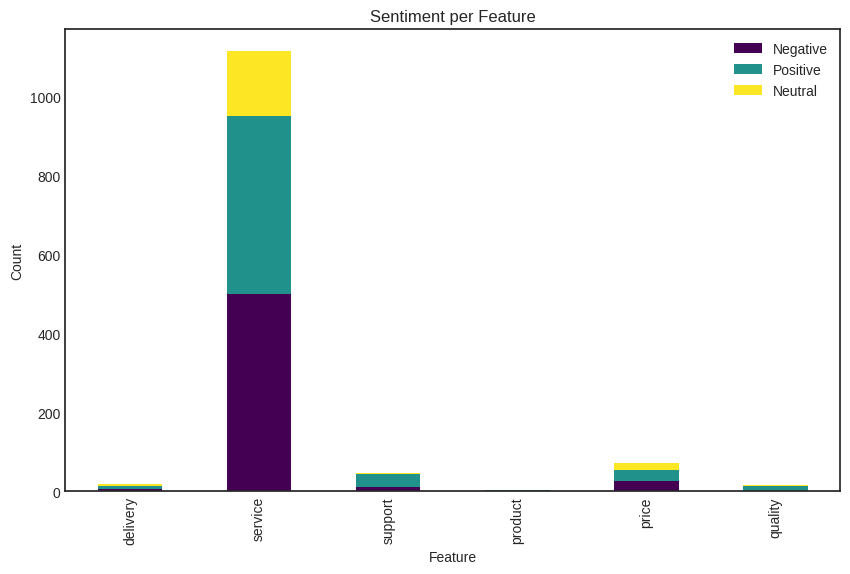

In [36]:
feature_sentiment_df.T.plot(kind='bar', figsize=(10,6), stacked=True, colormap='viridis')
plt.title("Sentiment per Feature")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.show()
